<a href="https://colab.research.google.com/github/AUMANSH/Data-Science-Projects/blob/main/EIGEN_FACES_USING_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, let's import the necessary libraries.



In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import imghdr
from IPython.display import display
from sklearn.metrics.pairwise import euclidean_distances

First, let's load the faces dataset and look at the same of it


In [ ]:
people = fetch_lfw_people(min_faces_per_person = 20, resize = .3) # this line only selects people who appear in the data set more than 20 times, to reduce noise during training. It also reduces the resolution by 30%

shapey = people.images.shape
print(shapey) #3023 images, 25 * 18 pixels

samplenum, height, width = shapey

targets = people.target_names
classes = targets.shape[0]

print(samplenum, targets, classes) #62 classes we are looking at which are named below


(3023, 37, 28)
3023 ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvio Berlusconi' 'T

The questions is, is this a pretty balanced list? That is, for the people in the dataset, do they have vastly different amounts of images that will interfere in model training? Let's use the IQR method to see if there are outliers in this data.



In [ ]:
print(type(people['target']))

frequencies = {}
for num in people['target']:
    if num in frequencies:
        frequencies[num] += 1
    else:
        frequencies[num] = 1

#print(frequencies) #frequencies of each person ID + number of images for that person

freqs = [frequencies[ID] for ID in frequencies]

freqs = pd.Series(freqs)
Q1 = freqs.quantile(.25)
Q3 = freqs.quantile(.75)

IQR = Q3-Q1

outliers = []
for frequency in freqs:
    if frequency > Q3 + 1.5*IQR:
        outliers.append(frequency)
    if frequency < Q1 - 1.5*IQR:
        outliers.append(frequency)

print(outliers)
print(len(people['target']))

<class 'numpy.ndarray'>
[77, 236, 530, 121, 71, 109, 144]
3023


We've identified outliers, but I have tested many balancing methods and they all reduce accuracy, so we will leave them...


In [ ]:
#DONT RUN - FAILED BALANCING

freqs = list(freqs)
#reduced_outlier = np.percentile(freqs, 90) #try log or square
#reduced_outlier_r = round(reduced_outlier)
#transformed_freqs = [round(math.sqrt(f)) for f in freqs]

for frequency in freqs:
    if frequency in outliers:
        if frequency > 100:
            freqs[freqs.index(frequency)] = 100


people['target'] = list(people['target'])
people['data'] = list(people['data'])

new_targets = []
new_data = [] #need to remove corresponding rows from the whole data section

index = -1

for person in frequencies:
    index += 1
    count = 0
    for i, ID in enumerate(people['target']): #using enumerate to get index of the row that we are adding to the new targets!
        if ID == person:
            if count < freqs[index]:
                new_targets.append(ID)
                new_data.append(people['data'][i]) #adding that same row to the new data!
                count += 1

print(len(new_targets))
print(sum(freqs))

people['target'] = np.array(new_targets) #change back to array to be used later!!
people['data'] = np.vstack(new_data) #vstack is used for making sure an array stays 2D. The X array needs to be 2D, since it is total images, and then pixels (which are like the features), and the y array is 1D, just being the target images\


1301
1301


Let's create our X and y, or our features and target for this dataset. X will be all the images in our set with their corresponding pixels, and y will be a corresponding set of these images. Our model should be able to take the images from X, in reduced dimensionality, and map it to the correct person in y.



In [ ]:
#the data and target are built into this sklearn library
X = people.data
y = people.target

print(X.shape) #3023 images, with 1036 pixels (25 by 18)
print(y.shape) #the target simply has the full photo, without the 'data' which is the breakdown of the pixels

(3023, 1036)
(3023,)


Let's create a function to plot our faces in X. We will just take a random sample of 5, to visualize what the data in this set really looks like



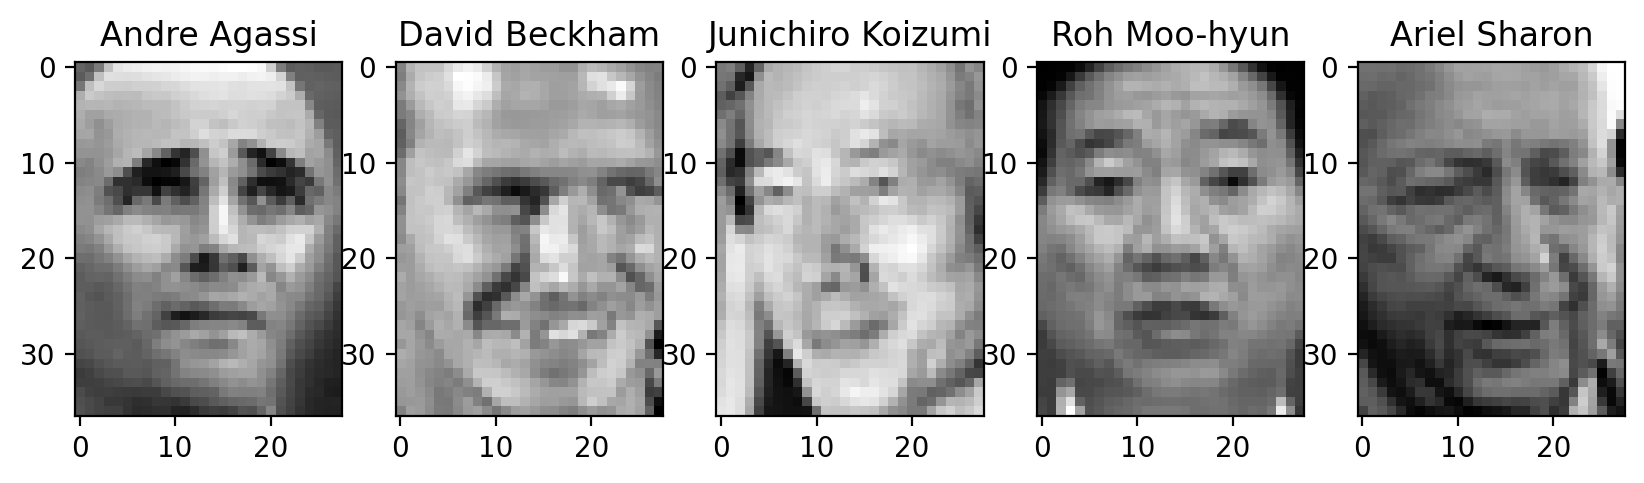

In [ ]:
def plot_face(face):
    height = 37
    width = 28

    plt.imshow(face.reshape(height, width), cmap=plt.cm.gray) #imshow is matplotlib function for showing b+w images

rand = np.random.permutation(3023) #taking a random sample of 5
plt.figure(figsize = (10,20))
numface = 5
for i in range(numface):
    index = rand[i]
    plt.subplot(1,numface, i+1)
    plot_face(X[index]) #accessing the index in X
    plt.title(targets[y[index]]) #titleing it with the name in y

PCA is a specific application of SVD. It is used especially for dimensionality reduction compared to SVD which is used more generally for matrix decomposition. PCA is essentially SVD on mean centered data. PCA centers the data, and then find the directions and strengths of maximum variance, which can be described just using the components of SVD. Centering is why we create that with Xs, but subtracting the mean of each column from that column.

Now, the built in PCA method centers the data automatically, and then applies the SVD randomized solver. Just to show how this can be broken down, I wrote the SVD equation below.

I will start with an ncomp = 20 value just to look at how it works, and the vectors, which means I am using the top 20 principal components, to further explore this data, but will hone this number as I go.



In [ ]:
Xmean = np.mean(X, 0) #getting mean of each column
Xs = X - Xmean[None, :] #centering the data by subtracting the mean

U, S, Vt = np.linalg.svd(Xs, full_matrices=False)

#computing PCA
ncomp = 20
pca = PCA(n_components = ncomp, svd_solver = 'randomized', whiten = True) #this whiten ensures that each component is scaled properly with a mean zero and variance of 1

#fit PCA to dataset
pca.fit(X)

PCA(n_components=20, svd_solver='randomized', whiten=True)

If we take a look at the principal components, we can see that there are twenty principal components, and each principal component has 1036 pixels. Each pixel is a dimension of the original data, and each principal component is a  dimension for the new data set \-\- **reducing the dimensionality to 20** but taking the weight of 1036 pixels each time, and creating 20 singular 'new directions' with the principal components .

Each combination of pixels for a principal component is different, allowing the PC to find a different direction that explains the most remaining variance in the data \- aka spans the largest amount of data.


In [ ]:
vtr_pca = pca.components_

print(vtr_pca)
print(len(vtr_pca[0]))
print(len(vtr_pca))

[[ 1.5103107e-02  1.8336453e-02  2.1820633e-02 ...  1.9569799e-02
   1.6433572e-02  1.3145215e-02]
 [ 2.8605346e-02  2.9495649e-02  3.4329277e-02 ... -6.2353093e-02
  -5.7493411e-02 -5.2017912e-02]
 [ 6.2912367e-02  6.4952336e-02  6.4683698e-02 ...  6.1008450e-02
   6.0752690e-02  5.4390900e-02]
 ...
 [-4.7624491e-02 -5.7500828e-02 -5.7664599e-02 ...  7.7752024e-02
   3.0300286e-02 -8.4997213e-04]
 [-8.9349719e-03 -2.2533169e-02 -1.3336543e-02 ... -9.8967403e-03
   5.4023266e-02  8.6240150e-02]
 [-1.2648262e-02 -3.7516854e-03  1.2098099e-05 ... -2.1603705e-02
   1.0657207e-02  2.1914478e-02]]
1036
20


could show more visualization of the different PC's working together, or how many you need, but for now, let's move on to SVM!!



<span style='font-size:x-large'>Building Our Face Classification Model using SVM</span>

<span style='font-size:medium'>A SVM \(support vector machine\) model is another supervised machine learning model which especially excels with classification. SVM works by finding some plane to divide the data into different classification groups. The models aims to maximize the distance between the hyperplane and the data on either side to reduce classification error, finding the "hard margin." SVM can work with n\-dimensional data, which makes it useful for PCA models such as this one, which, even after dimensionality reduction through PCA have lots of dimensions impacting the PCs and thus the classification as one of the people in our dataset.</span>

<span style='font-size:medium'>Source: </span>[https://www.geeksforgeeks.org/support\-vector\-machine\-algorithm/](https://www.geeksforgeeks.org/support-vector-machine-algorithm/)



In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = .25, stratify = y, random_state = 25)

<span style='font-size:medium'>Now, we can loop over the different hyper\-parameters to find the best number of principal components to use, the gamma value of the SVM, and the c value constant of the SVM.</span>

- <span style='font-size:medium'>PCs: Tests how much reduction in dimensionality there should be. </span>
  - <span style='font-size:medium'>Lots of PCs could overfit the data and be too sensitive when identifying images.</span>
  - <span style='font-size:medium'>Too few PCs may underfit the data, and create lots of error in classification.</span>
- <span style='font-size:medium'>Gamma: controls how far influence of a single training example on the model. </span>
  - <span style='font-size:medium'>A small gamma means that points far away from each other still influence each other in terms of classification. A small gamma can be prone to underfitting.</span>
  - <span style='font-size:medium'>A large gamma means the distance between data plays a much larger role in classification, which makes a large gamma prone to overfitting, especially on more noisy data</span>
- <span style='font-size:medium'>C value: C is a constant that controls the penalty for misclassification \-\- essentially how "strict" you model is.</span>
  - <span style='font-size:medium'>A high c values tries to classify all the training example correctly by penalizing misclassified points a lot. This can be prone to overfitting since it creates a more complex decision boundary</span>
  - <span style='font-size:medium'>A low C value allows for more misclassifications and can lead to underfitting.</span>

<span style='font-size:medium'>Let's test them below!</span>



In [ ]:
#creating some test options
test_pcs = [25, 50, 75, 100, 125, 150, 175, 200]
test_gammas = [1e-3, 4e-3,1e-2,1e-1]
test_c = [.1,1,10,.01, 100, 1000]

best_acc = 0

for pc in test_pcs:
    pca = PCA(n_components = pc, svd_solver = 'randomized', whiten = True)
    pca.fit(Xtrain)

    #transforming the Xtrain and Xtest
    Xtranstr = pca.transform(Xtrain)
    Xtransts = pca.transform(Xtest)

    for gamma in test_gammas:
        for c in test_c:
            svc = SVC(C=c, kernel = 'rbf', gamma = gamma)
            svc.fit(Xtranstr, ytrain)

            prediction = svc.predict(Xtransts) #predicting name labels
            acc = np.mean(prediction == ytest) #finds mean, between 0 and 1, of this boolean to see if the prediction matches the real ytest

            if acc > best_acc:
                best_acc = acc
                good_gam = gamma
                good_pc = pc
                good_c = c

optimals = good_pc, good_gam, good_c, best_acc
print(optimals)

(75, 0.01, 10, 0.6283068783068783)


One important note, you will notice we transform the Xtrain and Xtest sets to reduce the dimensionality per the principal components but not the ytrain and ytest sets. This is because we are looking at the PCs of just the input imgage, not the cooresponding pair.


Now, let's refit our model with the best classifier!


In [ ]:
pcs = good_pc
gamma = good_gam
c = good_c

pca = PCA(n_components = pcs, svd_solver = 'randomized', whiten = True)
pca.fit(Xtrain)

Xtranstr = pca.transform(Xtrain)
Xtransts = pca.transform(Xtest)

svc = SVC(C=c, kernel='rbf', gamma = gamma)
svc.fit(Xtranstr, ytrain)

predictions = svc.predict(Xtransts)#testing Xtest values

print(np.mean(predictions == ytest)) #seeing accuracy of model

0.6216931216931217


We can see that our accuracy definitely has some variability. Some have really high precision and accuracy \(likely the images with more photos, or very distinct features\), and others have low ones, or really variable ones. This is likely due to our class imbalance, but some of it is natural just considering some people have more promient features than others.


In [ ]:
print(classification_report(ytest, predictions, target_names = targets))
print(confusion_matrix(ytest, predictions, labels = range(classes)))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.67      0.50      0.57        12
             Alvaro Uribe       0.60      0.60      0.60        10
          Amelie Mauresmo       1.00      0.33      0.50         6
             Andre Agassi       0.21      0.27      0.24        11
           Angelina Jolie       1.00      0.17      0.29         6
             Ariel Sharon       0.43      0.65      0.52        23
    Arnold Schwarzenegger       0.36      0.38      0.37        13
     Atal Bihari Vajpayee       0.83      0.71      0.77         7
             Bill Clinton       0.75      0.33      0.46         9
             Carlos Menem       1.00      0.33      0.50         6
             Colin Powell       0.48      0.67      0.56        30
            David Beckham       0.29      0.22      0.25         9
          Donald Rumsfeld       0.52      0.77      0.62        30
         George Robertson       1.00      0.43      0.60     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Let's visualize some of our correct and incorrect predictions below:



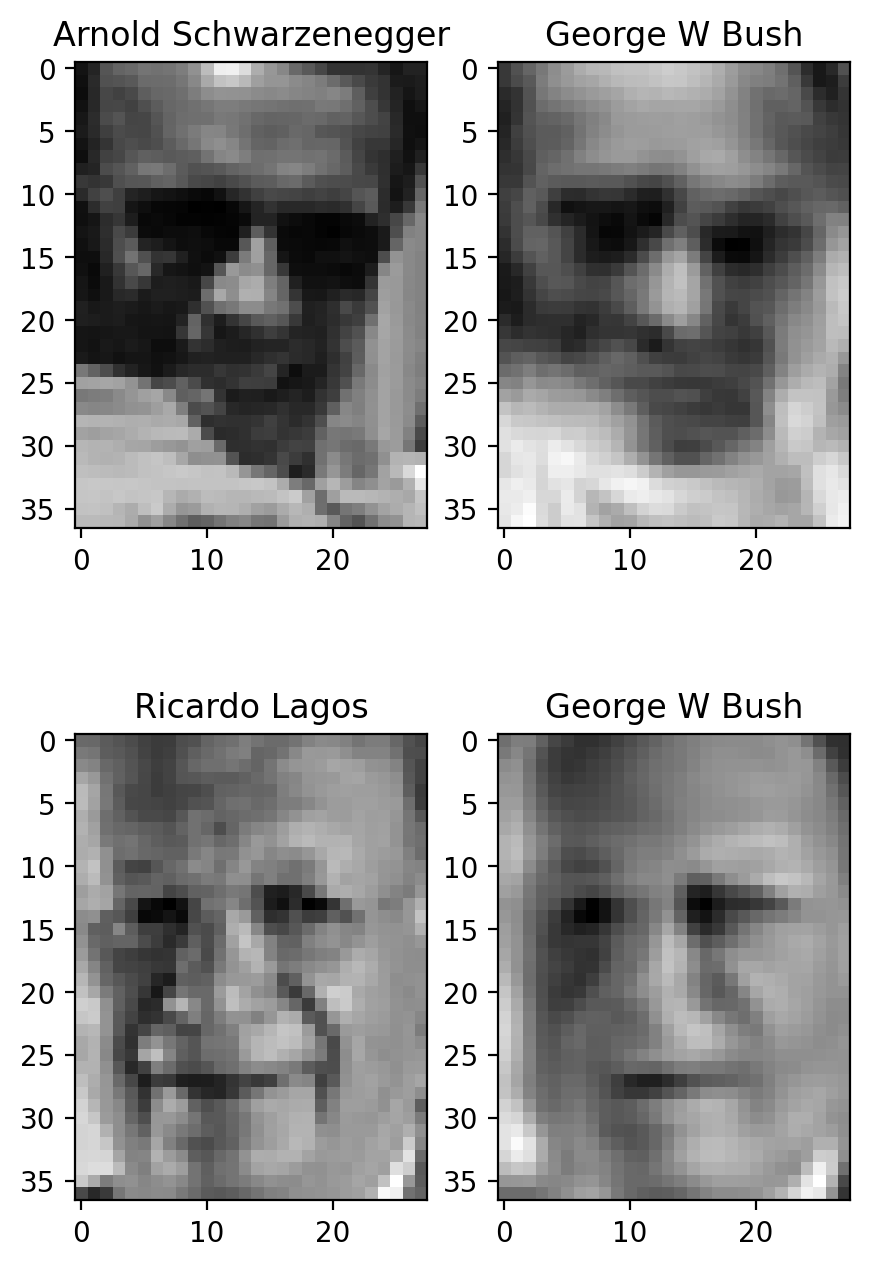

<Figure size 1200x700 with 0 Axes>

In [ ]:
correct_index = np.where(predictions != ytest)[0][:2] #to see correct/incorrect, just change predictions == ytest to predictions != ytest
correct_origin = Xtest[correct_index, :]
correct_pca = pca.inverse_transform(Xtransts[correct_index, :])

plt.figure(figsize=(5,8))
for i in range(2):
    plt.subplot(2,2,2*i+1)
    plot_face(correct_origin[i,:])
    plt.title(targets[ytest[correct_index[i]]])

    plt.subplot(2,2,2*i+2)
    plot_face(correct_pca[i,:])
    plt.title(targets[predictions[correct_index[i]]])

plt.show()
plt.tight_layout()

<span style='font-size:x-large'>Finding Famous Lookalikes!</span>

<span style='font-size:medium'>Let's load some images of my friends to start, and look at their type and size. We will be using the .convert\('L'\) command to load the images in grayscale form, since that is how they are loaded in our training data. </span>


In [ ]:
ellie_img = Image.open("ellie.jpg").convert('L')
lily_img = Image.open('lily.jpg').convert('L')
peter_img = Image.open('peter.jpg').convert('L')

peter2_img = Image.open('peter2.jpg').convert('L')
ellie2_img = Image.open('ellie2.jpg').convert('L')
lily2_img = Image.open('lily2.jpg').convert('L') # the L converts to grayscale

#print("ellie.jpg is:", imghdr.what("ellie.jpg")) #check to make sure it is jpg
print(ellie_img.size)

(1397, 1765)


We can see this image of Ellie is 1397 pixels by 1765 pixels, wayyy too big for our model, which deals with 37 by 1828since it is more low resolution. Let's make a model to resize it, standardize it, and apply our model to find her lookalike!


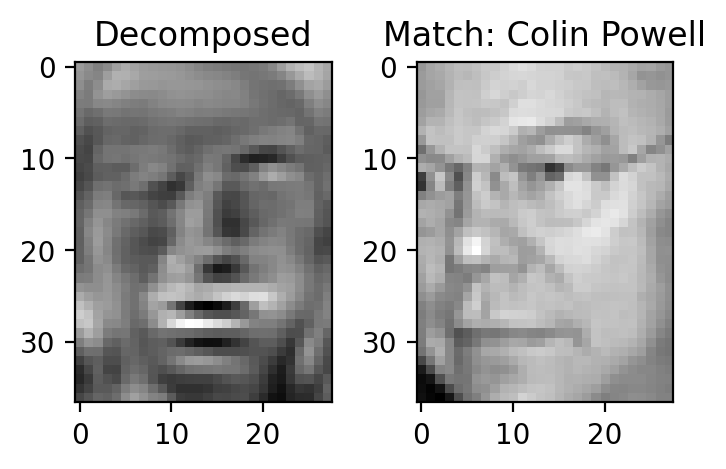

(971, array([[0.52078454, 0.49116348, 0.4545454 , ..., 0.24275109, 0.30396118,
        0.36566843]]), 'Colin Powell')


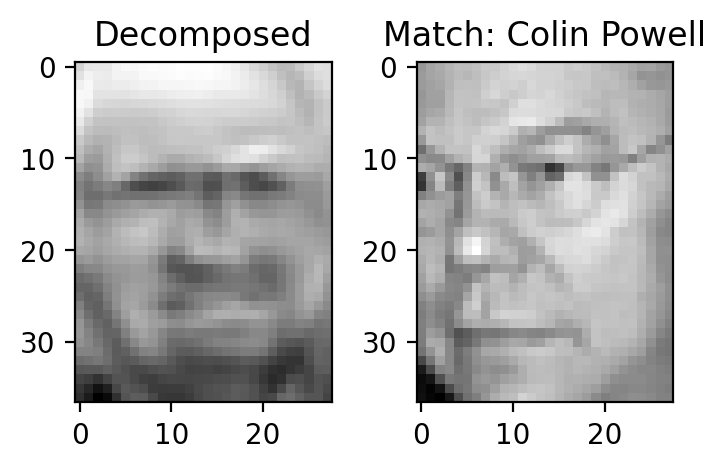

(971, array([[0.64252569, 0.69058588, 0.69659676, ..., 0.30517506, 0.30622135,
        0.26029893]]), 'Colin Powell')


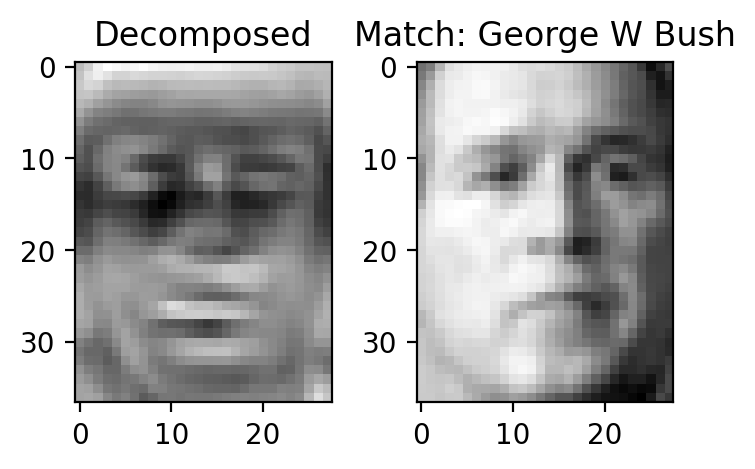

(1348, array([[0.74685207, 0.80878547, 0.91068206, ..., 0.72917715, 0.85051561,
        0.77702311]]), 'George W Bush')


In [ ]:
def lookalike(img):
    newsize = (37, 28)
    img = img.resize(newsize)

    im_array = np.array(img) / 255 # convert to array and normalize
    im_flat = im_array.flatten() #flatten to make 1D vector

    X_person = im_flat.reshape(1, -1) #reshape to use for PCA, which needs (1,features) format (37 * 28 --> (,1036) --> (1,1036))

    test_image = pca.transform(X_person)

    test_prediction = svc.predict(test_image)
    prediction_id = int(test_prediction[0])

    correct_pca = pca.inverse_transform(test_image)

    # best match from the dataset using euclidian distance, since some people have many images
    matching_indices = np.where(people.target == prediction_id)[0] #all images of matching person
    matching_faces_pca = pca.transform(people.data[matching_indices]) #applying PCA
    distances = euclidean_distances(test_image, matching_faces_pca) #finding difference from image and the match PCA image

    best = matching_indices[np.argmin(distances)]# ID value of the best match! (argmin = values of minimum distance)

    # Plot decomposed and best match
    plt.figure(figsize=(5, 8))

    plt.subplot(1, 3, 2)
    plot_face(correct_pca[0])
    plt.title("Decomposed")

    plt.subplot(1, 3, 3)
    plot_face(people.data[best]) #plotting the data from the index of the best image
    plt.title(f"Match: {targets[prediction_id]}") #ID is index in targets

    plt.tight_layout()
    plt.show()

    return best, correct_pca, targets[prediction_id]

print(lookalike(ellie_img))
print(lookalike(lily_img))
print(lookalike(peter_img))

Ok... you'll notice that my decomposed images look different than the ones above \-\- worse! The reasoning for this could come down to scaling, if we take a look at the cell below, we will see that the range of the cell values between my original data and my image array are pretty equal \-\- which means they are scaled in about the same way.

The issue could be related to just noisy images in comparison to the really nice ones from the original dataset, this could really mess up the PCA decomp.



In [ ]:
newsize = (37, 28)
ellie_img = ellie_img.resize(newsize)
im_array = np.array(ellie_img) / 255

print(im_array.shape, im_array.min(), im_array.max())
print(people.data[0].shape, people.data[0].min(), people.data[0].max())

(28, 37) 0.050980392156862744 0.996078431372549
(1036,) 0.050980393 0.9620915


Ok, let's use some more cropped version to block our some noise... maybe a little better?? I don't really know \-\- still pretty wonky


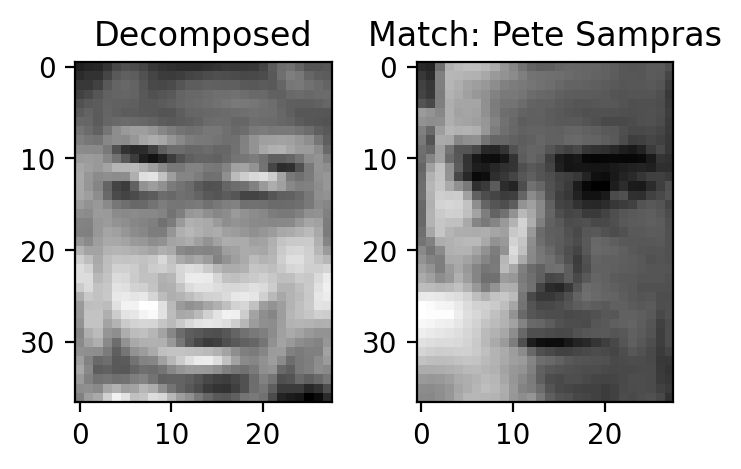

(1540, array([[0.21618192, 0.22657669, 0.23343944, ..., 0.14360417, 0.17087049,
        0.24349837]]), 'Pete Sampras')


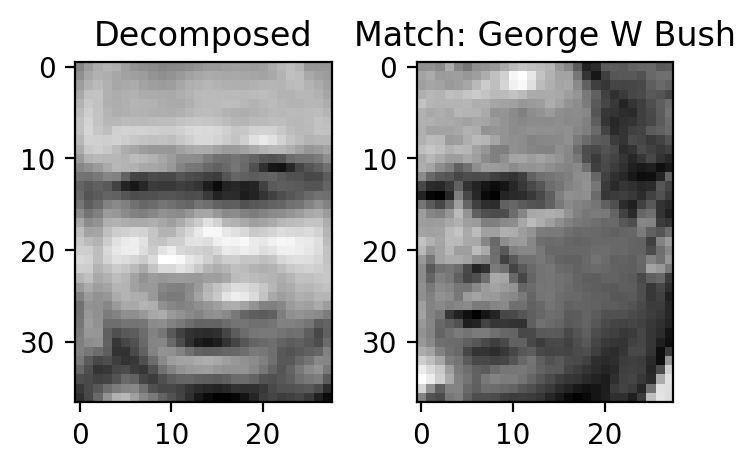

(550, array([[0.48973345, 0.54388494, 0.58100076, ..., 0.31207287, 0.24814748,
        0.20134836]]), 'George W Bush')


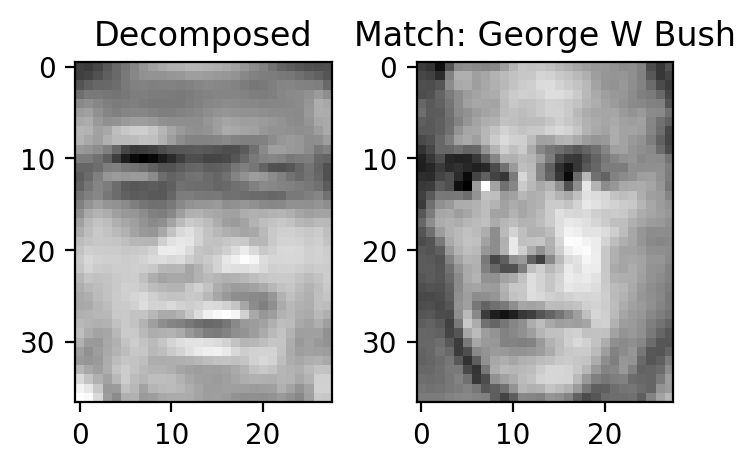

(348, array([[0.23505501, 0.22256117, 0.24983149, ..., 0.46246951, 0.55877764,
        0.55580843]]), 'George W Bush')


In [ ]:
print(lookalike(ellie2_img))
print(lookalike(lily2_img))
print(lookalike(peter2_img))

Regardless let's take a look at what our model is seeing using a heatmap of ellie2 lookalike


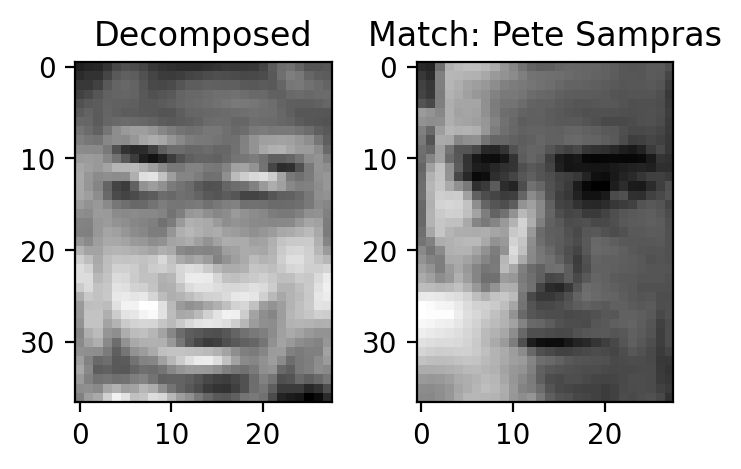

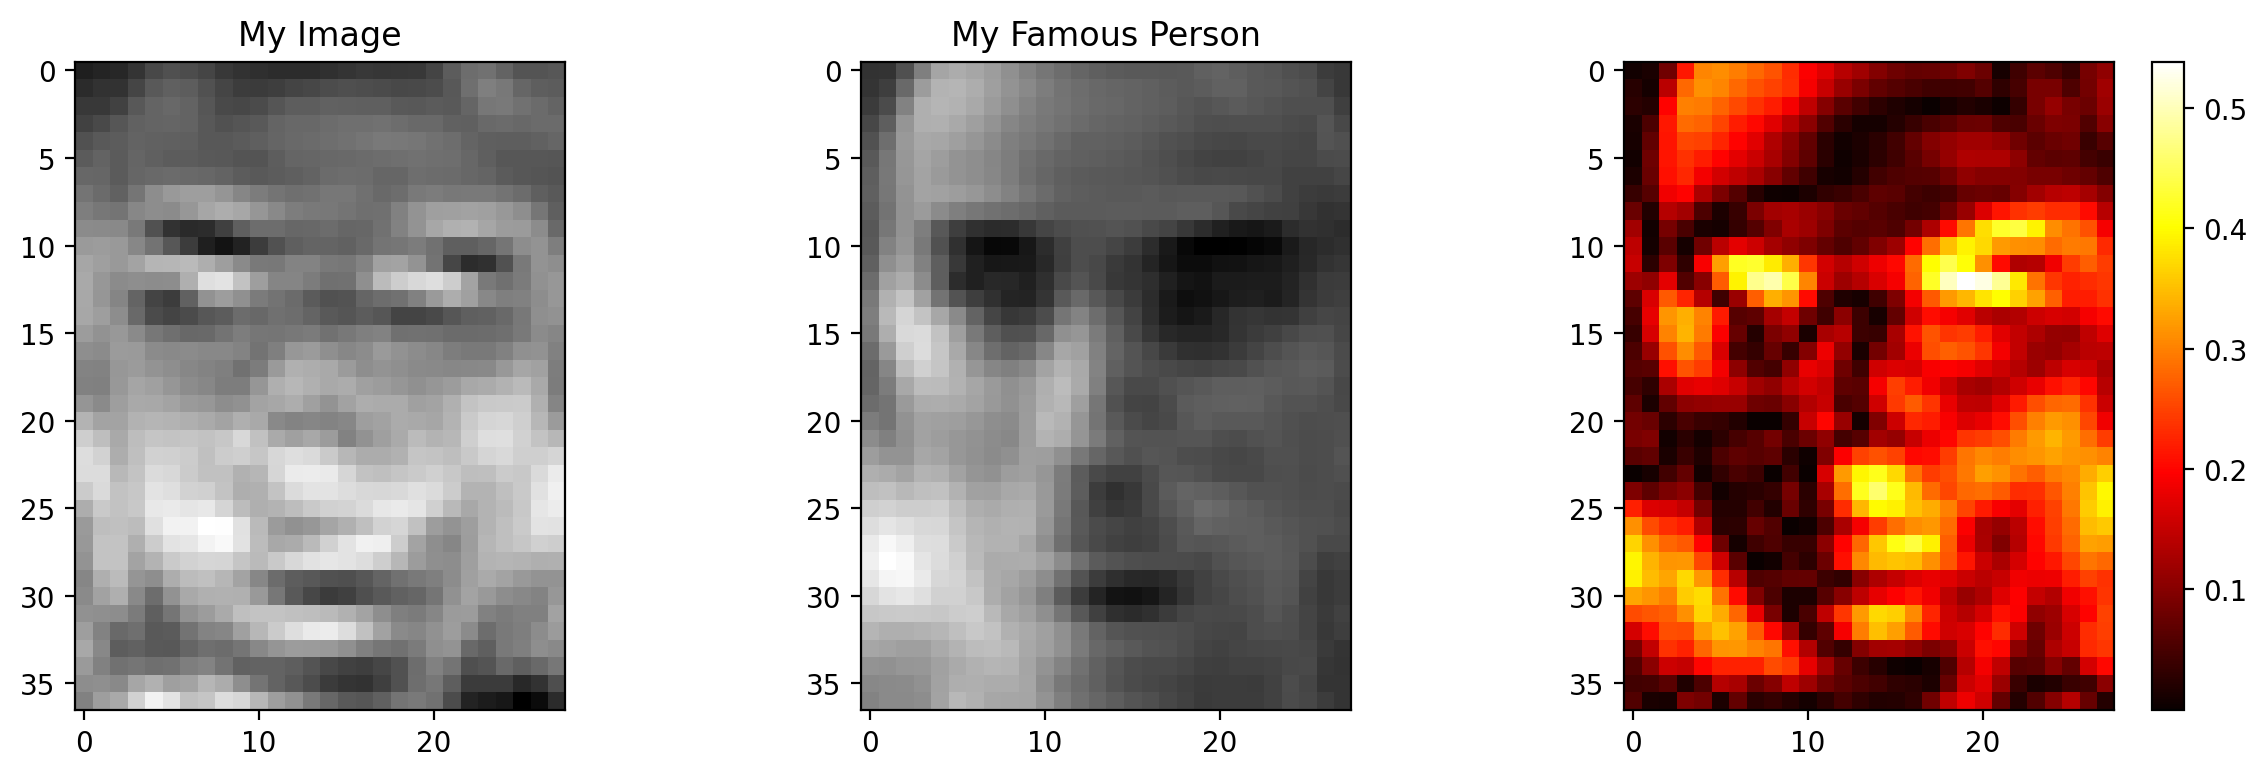

In [ ]:
def heatmap(img1, img2):
    differences = np.abs(img1-img2) #finding difference between each pixel
    map_diff = differences.reshape(37,28) #matching pixels to my image shapes

    plt.figure(figsize = (12,4))

    plt.subplot(1,3,1) #subplots are just to keep plots together so you don't have to use .show() a ton -- just plots them side by side on the larger figure --> in this case we create three, and say which one we want to be which (last number)
    plot_face(img1)
    plt.title('My Image')

    plt.subplot(1,3,2)
    plot_face(img2)
    plt.title('My Famous Person')

    plt.subplot(1,3,3)
    plt.imshow(map_diff, cmap = 'hot')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

best_id, correct_pca, name = lookalike(ellie2_img) #need to return the pixel values post transformed to find differences

#this is the same process we did in the lookalike function to deocmpose our images - have a 1D array, apply pca, and then do inverse pca which is used for VISUALIZATION -- reconstructs image from those components

im2 = people.data[best_id].flatten()
img2_shape = im2.reshape(1, -1)
img2_pca = pca.transform(img2_shape)
img2 = pca.inverse_transform(img2_pca)[0]

heatmap(correct_pca[0], img2)

SOURCES I used for background info, and learning how to code new aspects!

---



Python Pillow Tutorial. \(2024, June 16\). Geeks for Geeks. Retrieved June 3, 2025, from https://www.geeksforgeeks.org/python\-pillow\-tutorial/

Rangan, S. \(2020, November 9\). Intro to ML. Unit 11. PCA. Section 5. EigenFaces Demo \[Video\]. Youtube. https://www.youtube.com/watch?v=Mh64RWAy5As

Support Vector Machine \(SVM\) Algorithm. \(2025, May 28\). Geeks for Geeks. Retrieved June 3, 2025, from https://www.geeksforgeeks.org/support\-vector\-machine\-algorithm/

Wood, K. \(2023, May 25\). OpenCV Python Read And Write Pixels \[Video\]. Youtube. https://www.youtube.com/watch?v=Idt1hngS1ms

How to draw 2D Heatmap using Matplotlib in python? \(2025, May 27\). Geeks for Geeks. [https://www.geeksforgeeks.org/how\-to\-draw\-2d\-heatmap\-using\-matplotlib\-in\-python/](https://www.geeksforgeeks.org/how-to-draw-2d-heatmap-using-matplotlib-in-python/)
